## This script is for confirmation of spot algorithm

In [1]:
import scanpy as sc
import squidpy as sq

In [2]:
# read in the pertrub-view data
import pandas as pd
import numpy as np

fdata_list = []
for sample in ['GSM5808054_KP_1', 'GSM5808055_KP_2', 'GSM5808056_KP_3', 'GSM5808057_KP_4']:
    positions = pd.read_csv(f'GSE193460_RAW/{sample}_tissue_positions_list.csv',
                            header=None, names=['barcode', 'pos_1', 'pos_2', 'pos_3', 'x', 'y'])
    positions.set_index('barcode', inplace=True)
    annotations = pd.read_csv(f'GSE193460_RAW/{sample}_spot_annotation.csv').set_index('barcode')
    positions = pd.concat([positions, annotations], axis=1, join='inner')
    positions.head()

    fdata = sc.read_10x_h5(f'GSE193460_RAW/{sample}_filtered_feature_bc_matrix.h5')

    fdata = fdata[positions.index].copy()
    fdata.obs = pd.concat([fdata.obs, positions], axis=1, join='inner')

    fdata.obsm['spatial'] = np.array([fdata.obs['x'].tolist(), fdata.obs['y'].tolist()]).T
    fdata.var_names_make_unique()

    fdata_list.append(fdata)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: Use

In [3]:
fdata = sc.concat(fdata_list[0], axis=0, label='sample')
fdata.obs

,pos_1,pos_2,pos_3,x,y,nCount_Spatial,nFeature_Spatial,kmeans,leiden_clusters,phenotypes,sample
ACGGCGGGTTGCCCTG-1,1,5,31,771,1315,5798,2810,normal,NaN,NaN,0
GTGCGCAGCTTGCTCC-1,1,5,33,771,1364,5855,2903,normal,NaN,NaN,1
TCACTATCGTGCAATC-1,1,4,34,727,1389,6631,3060,normal,NaN,NaN,2
AGTCACTCCGCCTCAT-1,1,6,30,814,1290,7974,3300,normal,NaN,NaN,3
GCAGCGGTGGGCATTA-1,1,7,31,858,1315,13236,4323,normal,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...
ATGTCATAATAAACGA-1,1,77,63,3882,2125,4449,2222,normal,NaN,NaN,1898
CTTAATCGACTTAGTA-1,1,76,64,3839,2149,2809,1548,normal,NaN,NaN,1899
CTAAAGGATGAGATAC-1,1,77,65,3882,2174,4038,2065,normal,NaN,NaN,1900
GTGCTATCCAGCTGGA-1,1,76,66,3839,2199,4102,2090,normal,NaN,NaN,1901


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


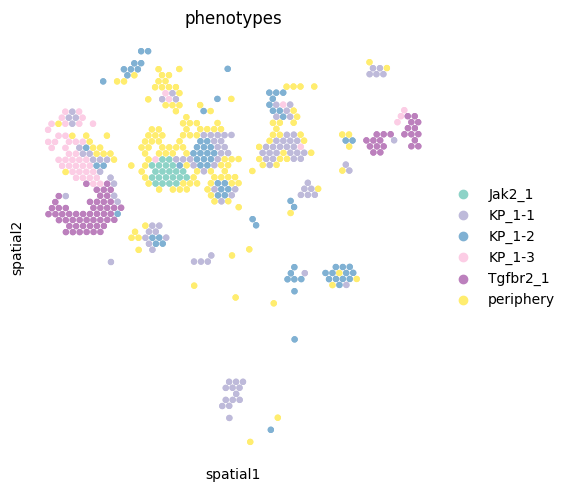

In [4]:
import seaborn as sns
fdata.obsm['spatial'] = np.array([fdata.obs['y'].tolist(), fdata.obs['x'].tolist()]).T
axs = sq.pl.spatial_scatter(fdata[~fdata.obs['phenotypes'].isna()], color='phenotypes', 
                            shape=None, size=50, vmax=20, return_ax=True, palette='Set3')
sns.despine(left=True, bottom=True)

In [5]:
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN

def cluster_by_DBSCAN(adata, guide, eps=5, min_samples=20):
    guide_adata = adata[adata.obs[guide]==1].copy()
    # guide_dots = guide_adata.obs[["array_col","array_row"]]
    guide_dots = guide_adata.obsm['spatial']
    # guide_dots = guide_dots.to_numpy()

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(guide_dots)
    print("Number of Clusters (excluding noise):", len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0))

    cluster_labels = clustering.labels_
    guide_adata.obs["dbscan_cluster"] = "Noise"
    guide_adata.obs.loc[guide_adata.obs[guide] == 1, "dbscan_cluster"] = cluster_labels.astype(str)

    return guide_adata

def define_region(guide_adata, label="0", mode="most", density_level=7):
    labels = np.array(guide_adata.obs["dbscan_cluster"])

    if mode == "most":
        filtered_labels = labels[labels != "-1"]
        unique_labels, counts = np.unique(filtered_labels, return_counts=True)
        max_count_index = np.argmax(counts)
        label = unique_labels[max_count_index]

    # guide_dots = guide_adata.obs[["array_col","array_row"]]
    guide_dots = guide_adata.obsm['spatial']
    # guide_dots = guide_dots.to_numpy()
    cluster_points = guide_dots[labels == label]

    if cluster_points.size == 0:
        raise ValueError(f"No points found for label {label}. Function will terminate.")

    kde = gaussian_kde(cluster_points.T)

    x_min, x_max = cluster_points[:, 0].min() - 1, cluster_points[:, 0].max() + 1
    y_min, y_max = cluster_points[:, 1].min() - 1, cluster_points[:, 1].max() + 1
    x_range = np.arange(x_min, x_max + 1)
    y_range = np.arange(y_min, y_max + 1)
    X, Y = np.meshgrid(x_range, y_range)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])

    Z = kde(grid_coords).reshape(X.shape)
    density_levels = np.linspace(Z.min(), Z.max(), density_level)
    level_density = density_levels[2]

    core_points_mask = Z >= level_density
    core_points = np.column_stack((X[core_points_mask], Y[core_points_mask]))

    core_points_df = pd.DataFrame(core_points, columns=['array_col', 'array_row'])

    return core_points_df

Text(0.5, 1.0, '')

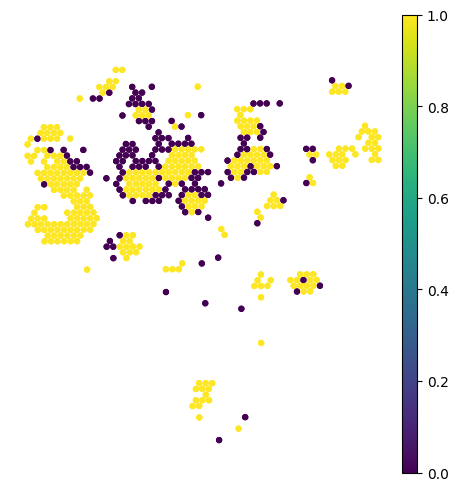

In [6]:
fdata.obs['guide'] = (fdata.obs['phenotypes'].str.contains('_'))

from igraph import palettes
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.facecolor'] = 'white'
# pdata = fdata[~fdata.obs['leiden_clusters'].isna()]
pdata = fdata
# pdata.obs['dbscan_cluster'] = pdata.obs['dbscan_cluster'].astype(str)
ax = sq.pl.spatial_scatter(pdata,
                           color='guide', shape=None, size=50, vmax=1, return_ax=True,
                           palette='tab20c')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=True, borderaxespad=0., facecolor='white', edgecolor='white')
plt.rcParams['figure.facecolor'] = 'white'

sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')

Number of Clusters (excluding noise): 15


/tmp/ipykernel_5702/1517907.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pdata.obs['dbscan_cluster'] = pdata.obs['dbscan_cluster'].astype(str)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


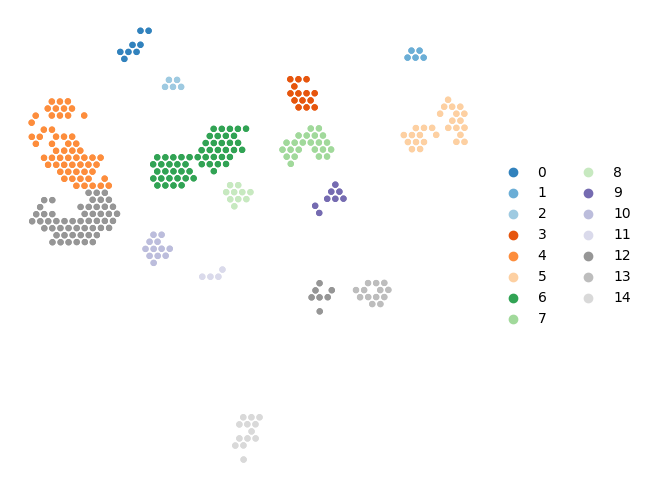

In [7]:
guide_data = cluster_by_DBSCAN(fdata, guide='guide', eps=100, min_samples=3)

from igraph import palettes
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.facecolor'] = 'white'
# pdata = fdata[~fdata.obs['leiden_clusters'].isna()]
pdata = guide_data[guide_data.obs['dbscan_cluster'] != '-1']
pdata.obs['dbscan_cluster'] = pdata.obs['dbscan_cluster'].astype(str)
pdata.obs.loc[pdata.obsm['spatial'][:, 1] > 1950, 'dbscan_cluster'] = pdata.obs[pdata.obsm['spatial'][:, 1] > 1950]['dbscan_cluster'].map(lambda x: '12' if x == '4' else x).tolist()
pdata.obs.loc[pdata.obsm['spatial'][:, 0] < 1770, 'dbscan_cluster'] = pdata.obs[pdata.obsm['spatial'][:, 0] < 1770]['dbscan_cluster'].map(lambda x: '11' if x == '5' else x).tolist()
ax = sq.pl.spatial_scatter(pdata,
                           color='dbscan_cluster', shape=None, size=50, vmax=1, return_ax=True,
                           palette='tab20c')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=True, borderaxespad=0., facecolor='white', edgecolor='white')
# ax.set_facecolor('white')

sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('./supplementary_images/perturb_view_spot.pdf', bbox_inches='tight', format='pdf')

plt.show()

KP_1-2
Number of Clusters (excluding noise): 4
KP_1-1
Number of Clusters (excluding noise): 6
KP_1-3
Number of Clusters (excluding noise): 1
Tgfbr2_1
Number of Clusters (excluding noise): 7
Jak2_1
Number of Clusters (excluding noise): 2


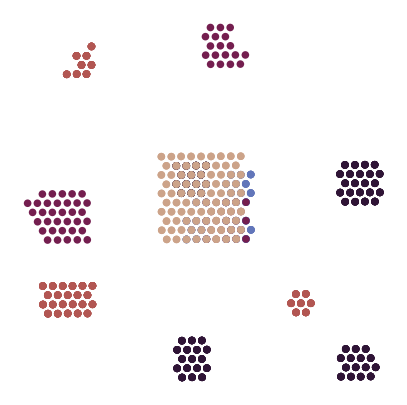

In [9]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

colors = sns.color_palette("twilight", n_colors=len(fdata.obs['phenotypes'].unique()))
for i, guide in enumerate(fdata.obs['phenotypes'].unique()):
    if type(guide) == float or '_' not in guide: continue
    print(guide)
    fdata.obs['guide'] = (fdata.obs['phenotypes'] == guide).astype(int)
    guide_data = cluster_by_DBSCAN(fdata, guide='guide', eps=50, min_samples=5)
    for guide in np.unique(guide_data.obs['dbscan_cluster']):
        if guide == '-1': continue
        df = define_region(guide_data, label=guide, mode="most", density_level=7)
        # Only plot points from guide_data that are in the current cluster
        dots = fdata.obsm['spatial'][np.isin(fdata.obsm['spatial'], df.to_numpy()).sum(axis=1) == 2]
        sns.scatterplot(x=dots[:, 0], y=dots[:, 1], ax=ax, s=30, edgecolor='none', color=colors[i])
ax.set_facecolor('white')
ax.invert_yaxis()
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

plt.savefig('./supplementary_images/perturb_view_kde.pdf', bbox_inches='tight', format='pdf')

In [18]:
import utils

In [19]:
gdata = guide_data[:, ~guide_data.var_names.str.contains('Igk')].copy()
gdata = utils.remove_mito_ribo_hk_lnc_genes(gdata)
sc.pp.pca(gdata)
sc.pp.neighbors(gdata, n_neighbors=6, n_pcs=30)
sc.tl.umap(gdata)
sc.tl.leiden(gdata, resolution=0.14)
gdata.obs.leiden.unique()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


['2', '0', '1']
Categories (3, object): ['0', '1', '2']

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


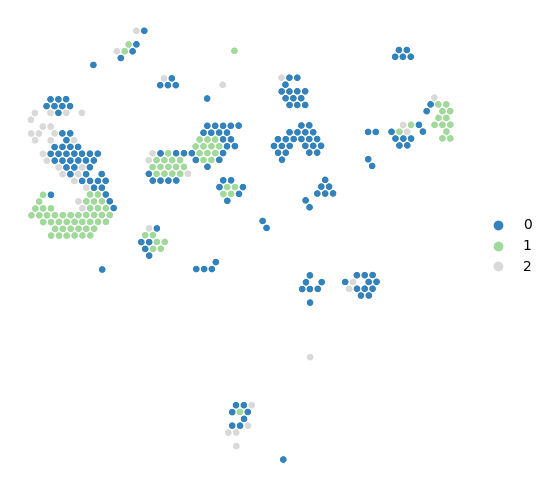

In [19]:
from igraph import palettes
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.facecolor'] = 'white'
# pdata = fdata[~fdata.obs['leiden_clusters'].isna()]
# pdata.obs['leiden_clusters'] = pdata.obs['leiden_clusters'].astype(str)
pdata = gdata
ax = sq.pl.spatial_scatter(pdata,
                           color='leiden', shape=None, size=50, vmax=20, return_ax=True,
                           palette='tab20c')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=True, borderaxespad=0., facecolor='white', edgecolor='white')
# ax.set_facecolor('white')

sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('./supplementary_images/perturb_view_cluster.pdf', bbox_inches='tight', format='pdf')

plt.show()

In [15]:
sc.get.rank_genes_groups_df(gdata, group='0', key='rank_genes_groups').to_csv('./rank_genes_groups_0.csv')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify futu

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


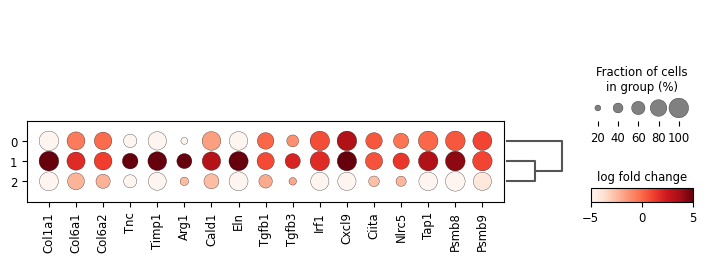

In [13]:
sc.tl.rank_genes_groups(gdata, groupby='leiden', method='wilcoxon')
# guide_data.var_names_make_unique()
fig = sc.pl.rank_genes_groups_dotplot(gdata, values_to_plot='logfoldchanges',
                                var_names=['Col1a1', 'Col6a1', 'Col6a2', 'Tnc', 'Timp1', 'Arg1', 'Cald1', 'Eln', 'Tgfb1', 'Tgfb3', 'Irf1', 'Cxcl9', 'Ciita', 'Nlrc5', 'Tap1', 'Psmb8', 'Psmb9'],
                                vmax=5, vmin=-5, return_fig=True)
# plt.rcParams['pdf.fonttype'] = 42
# fig.savefig('./supplementary_images/perturb_view_dotplot.pdf', bbox_inches='tight', format='pdf')
fig.show()

In [41]:
# sc.tl.score_genes(gdata, gene_list=['Actn2', 'Coro2b', 'Nrp1', 'Lpar1', 'Rgs4', 'Nox4', 'Fmn1', 'Stc1', 'Wasf3', 'Gpm6b', 'Asap3', 'Myo3b'], score_name='Myofibril')
sc.tl.score_genes(pdata, gene_list=["Pitx2", "Thbs1", "Id2", "Thbs2", "Gdf6", "Dcn", "Inhba", "Comp", "Bmp8a",
                                    "Tfdp1", "Bmp2", "Myc", "Tgfb3", "Thbs4", "Mapk3", "Bmpr1a", "Ltbp1", "Cdkn2b",
                                    "Acvr1", "Smad3", "E2f4", "Id1", "Smurf1", "Sp1", "Smad4"], score_name="TGFb")
sc.tl.score_genes(pdata, gene_list=["Il10", "Lck", "Tnf", "Nfatc2", "Cd4", "Rasgrp1", "Ptprc", "Cd247", "Map3k8", "Ppp3cc",
                                    "Card11", "Cd28", "Grap2", "Prkcq", "Itk", "Chp2", "Il4"], score_name="TCR_signaling")

In [23]:
pdata = gdata.copy()
sc.pp.normalize_total(pdata)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


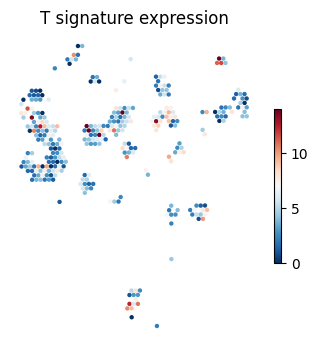

In [38]:
plt.figure(figsize=(4, 4))
scatter = sns.scatterplot(x=pdata.obsm['spatial'][:, 0], y=pdata.obsm['spatial'][:, 1],
                          c=pdata[:, ['Cd8a', 'Cd8b1', 'Cd3e', 'Cd3d', 'Cd3g']].X.toarray().sum(axis=1),
                          s=10, edgecolor='none', cmap='RdBu_r', vmax=14)
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('T signature expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.gca().invert_yaxis()

# 添加颜色条
plt.colorbar(scatter.collections[0], ax=plt.gca(), orientation='vertical', label='', shrink=0.5)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/perturb_view_t_expr.pdf', bbox_inches='tight', format='pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


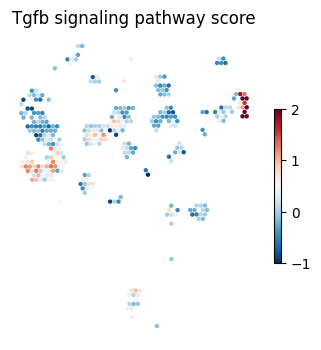

In [43]:
plt.figure(figsize=(4, 4))
scatter = sns.scatterplot(x=pdata.obsm['spatial'][:, 0], y=pdata.obsm['spatial'][:, 1],
                          c=pdata.obs.TGFb,
                          s=10, edgecolor='none', cmap='RdBu_r', vmax=2, vmin=-1)
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('Tgfb signaling pathway score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.gca().invert_yaxis()

# 添加颜色条
plt.colorbar(scatter.collections[0], ax=plt.gca(), orientation='vertical', label='', shrink=0.5)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/perturb_view_tgfb.pdf', bbox_inches='tight', format='pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


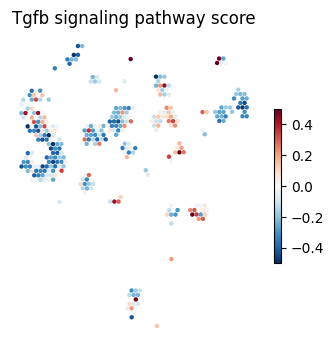

In [46]:
plt.figure(figsize=(4, 4))
scatter = sns.scatterplot(x=pdata.obsm['spatial'][:, 0], y=pdata.obsm['spatial'][:, 1],
                          c=pdata.obs.TCR_signaling,
                          s=10, edgecolor='none', cmap='RdBu_r', vmax=0.5, vmin=-0.5)
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('Tgfb signaling pathway score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.gca().invert_yaxis()

# 添加颜色条
plt.colorbar(scatter.collections[0], ax=plt.gca(), orientation='vertical', label='', shrink=0.5)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/perturb_view_tcr.pdf', bbox_inches='tight', format='pdf')
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/tmp/ipykernel_115200/2197114993.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

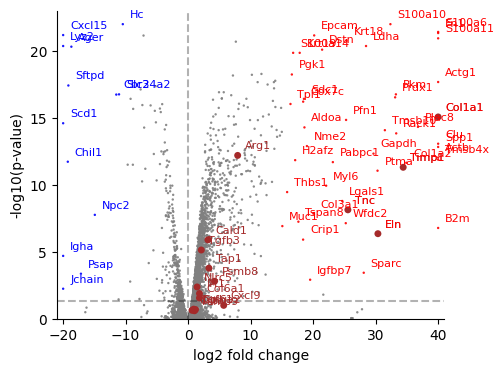

In [18]:
# 创建火山图
plt.figure(figsize=(5, 4))
sc.tl.rank_genes_groups(gdata, groupby='leiden', method='wilcoxon')
genes_of_interest = ['Col1a1', 'Col6a1', 'Col6a2', 'Tnc', 'Timp1', 'Arg1', 'Cald1', 'Eln', 'Tgfb1', 'Tgfb3', 'Irf1', 'Cxcl9', 'Ciita', 'Nlrc5', 'Tap1', 'Psmb8', 'Psmb9']
df = sc.get.rank_genes_groups_df(gdata, group='1', key='rank_genes_groups')
df_filtered = df[df['names'].isin(genes_of_interest)]
df = df[df['pvals_adj'] < 1]

# 绘制所有点
significant_up = df[(df['logfoldchanges'] > 15) & (df['pvals_adj'] < 0.01)]
significant_down = df[(df['logfoldchanges'] < -10) & (df['pvals_adj'] < 0.01)]
others = df[~df['names'].isin(significant_up['names']) & ~df['names'].isin(significant_down['names'])]

df['logfoldchanges'] = df['logfoldchanges'].clip(lower=-20, upper=40)
plt.scatter(others['logfoldchanges'], -np.log10(others['pvals_adj']),
           alpha=0.9, color='grey', s=3, edgecolor='none')
significant_up['logfoldchanges'] = significant_up['logfoldchanges'].clip(lower=-20, upper=40)
significant_down['logfoldchanges'] = significant_down['logfoldchanges'].clip(lower=-20, upper=40)
plt.scatter(significant_up['logfoldchanges'], -np.log10(significant_up['pvals_adj']),
           alpha=0.9, color='red', s=3, edgecolor='none')
plt.scatter(significant_down['logfoldchanges'], -np.log10(significant_down['pvals_adj']),
           alpha=0.9, color='blue', s=3, edgecolor='none')
plt.xlim(-21, 41)

# 标记感兴趣的基因
for gene in genes_of_interest:
    gene_data = df[df['names'] == gene]
    if not gene_data.empty:
        plt.scatter(gene_data['logfoldchanges'], 
                   -np.log10(gene_data['pvals_adj']),
                   color='brown', s=25, edgecolor='none')
        plt.annotate(gene,
                    (gene_data['logfoldchanges'].iloc[0], 
                     -np.log10(gene_data['pvals_adj']).iloc[0]),
                    xytext=(5, 5), textcoords='offset points', color='brown', size=8)

for _, gene in significant_up.iterrows():
    plt.annotate(gene['names'],
                (gene['logfoldchanges'], -np.log10(gene['pvals_adj'])),
                xytext=(5, 5), textcoords='offset points', color='red', size=8)

for _, gene in significant_down.iterrows():
    plt.annotate(gene['names'],
                (gene['logfoldchanges'], -np.log10(gene['pvals_adj'])),
                xytext=(5, 5), textcoords='offset points', color='blue', size=8)
        
plt.xlabel('log2 fold change')
plt.ylabel('-log10(p-value)') 

plt.ylim(0, 23)

# 添加参考线
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)

sns.despine()

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/perturb_view_volcano.pdf', bbox_inches='tight', format='pdf')
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify futu

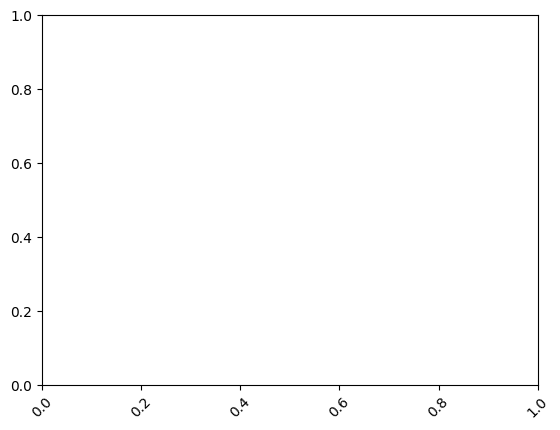

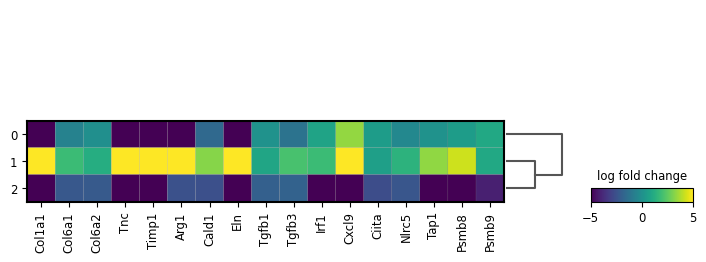

In [104]:
sc.tl.rank_genes_groups(gdata, groupby='leiden', method='wilcoxon')
# guide_data.var_names_make_unique()
# 获取所有基因名称
all_genes = gdata.var_names.tolist()
exclude_genes = ['Col1a1', 'Col6a1', 'Col6a2', 'Tnc', 'Timp1', 'Arg1', 'Cald1', 'Eln', 'Tgfb1', 'Tgfb3', 'Irf1', 'Cxcl9', 'Ciita', 'Nlrc5', 'Tap1', 'Psmb8', 'Psmb9']
filtered_genes = [g for g in all_genes if g not in exclude_genes]

# 绘制热图
fig = sc.pl.rank_genes_groups_matrixplot(gdata, 
                                     values_to_plot='logfoldchanges',
                                     var_names=exclude_genes, # Only use first 100 filtered genes
                                     return_fig=True,
                                     vmax=5, vmin=-5)

# Rotate x-axis labels after creating the plot
plt.xticks(rotation=45)

# plt.rcParams['pdf.fonttype'] = 42
# fig.savefig('./supplementary_images/perturb_view_dotplot.pdf', bbox_inches='tight', format='pdf')
fig.show()

/tmp/ipykernel_43174/1484896281.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pdata.obs['dbscan_cluster'] = pdata.obs['dbscan_cluster'].astype(str)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


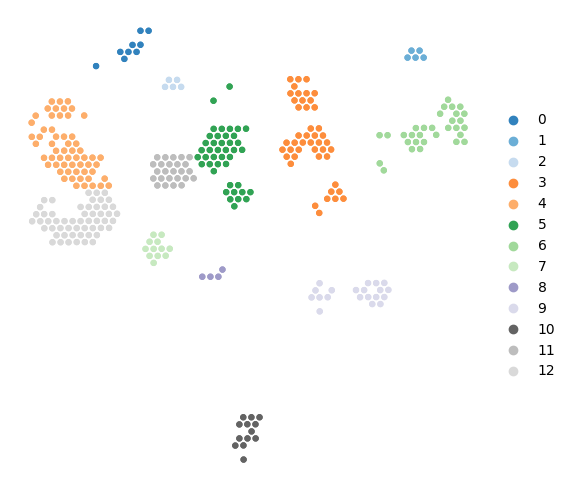

In [322]:
from igraph import palettes
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.facecolor'] = 'white'
# pdata = fdata[~fdata.obs['leiden_clusters'].isna()]
pdata = gdata[gdata.obs['dbscan_cluster'] != '-1']
pdata.obs['dbscan_cluster'] = pdata.obs['dbscan_cluster'].astype(str)
pdata.obs.loc[pdata.obsm['spatial'][:, 1] > 1950, 'dbscan_cluster'] = pdata.obs[pdata.obsm['spatial'][:, 1] > 1950]['dbscan_cluster'].map(lambda x: '12' if x == '4' else x).tolist()
pdata.obs.loc[pdata.obsm['spatial'][:, 0] < 1770, 'dbscan_cluster'] = pdata.obs[pdata.obsm['spatial'][:, 0] < 1770]['dbscan_cluster'].map(lambda x: '11' if x == '5' else x).tolist()
ax = sq.pl.spatial_scatter(pdata,
                           color='dbscan_cluster', shape=None, size=50, library_id='spatial', vmax=1, return_ax=True,
                           palette='tab20c')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=True, borderaxespad=0., facecolor='white', edgecolor='white')
ax.set_facecolor('white')

sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('./supplementary_images/perturb_view_spot.pdf', bbox_inches='tight', format='pdf')

plt.show()

In [325]:
len(gdata.obs[gdata.obsm['spatial'][:, 1] > 1950]['dbscan_cluster'].map(lambda x: '12' if x == '4' else x).tolist())

123

In [359]:
gdata.obs['dbscan_cluster'] = gdata.obs['dbscan_cluster'].astype(str)
gdata.obs.loc[gdata.obsm['spatial'][:, 1] > 1950, 'dbscan_cluster'] = gdata.obs[gdata.obsm['spatial'][:, 1] > 1950]['dbscan_cluster'].map(lambda x: '12' if x == '4' else x).tolist()
gdata.obs.loc[gdata.obsm['spatial'][:, 0] < 1770, 'dbscan_cluster'] = gdata.obs[gdata.obsm['spatial'][:, 0] < 1770]['dbscan_cluster'].map(lambda x: '11' if x == '5' else x).tolist()
gdata.obs['cluster'] = gdata.obs.dbscan_cluster.map({
    '0': 'KP_1-2.1',
    '1': 'KP_1-1.1',
    '2': 'KP_1-1.2',
    '3': 'KP_1-1.3',
    '4': 'KP_1-3.1',
    '5': 'KP_1-2.2',
    '6': 'Tgfbr2_1',
    '7': 'KP_1-1.4',
    '8': 'KP_1-1.5',
    '9': 'KP_1-2.3',
    '10': 'KP_1-1.6',
    '11': 'Jak2_1',
    '12': 'Tgfbr2_1'
})
cdf = gdata.obs[['cluster', 'leiden']].groupby('leiden').value_counts().unstack()

/tmp/ipykernel_43174/203290859.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdf = gdata.obs[['cluster', 'leiden']].groupby('leiden').value_counts().unstack()


In [360]:
pdf = cdf.div(cdf.sum(axis=0), axis=1).T.dropna().T
l2fc_df = pdf.div(pdf.mean(axis=1), axis=0).apply(np.log2)
l2fc_df

cluster,Jak2_1,KP_1-1.1,KP_1-1.2,KP_1-1.3,KP_1-1.4,KP_1-1.5,KP_1-1.6,KP_1-2.1,KP_1-2.2,KP_1-2.3,KP_1-3.1,Tgfbr2_1
leiden,,,,,,,,,,,,
0,-1.057841,0.586015,0.264087,0.553593,-0.677019,0.586015,-0.307070,-0.261982,-0.162446,0.434012,-0.024039,-1.501448
1,1.465004,-inf,-inf,-inf,1.301506,-inf,-1.398934,0.131581,0.909188,-inf,-inf,1.774758
2,-0.126182,-inf,0.610783,-2.559142,-0.652251,-inf,1.554200,0.762786,-2.459606,-0.389217,1.396659,-0.891717


In [361]:
from scipy.stats import chi2_contingency
chi_df = cdf.copy()
chi_df['sum'] = cdf.sum(axis=1)

pval_df = pd.DataFrame(index=chi_df.index, columns=chi_df.columns)
for i in chi_df.index:
    pval_df.loc[i, :] = chi_df.apply(lambda x: chi2_contingency([[x[i] + 1, chi_df.loc[i, 'sum'] + 1], [x[~(chi_df.index == i)].sum(), chi_df.loc[~(chi_df.index == i), 'sum'].sum()]])[1], axis=0)
pval_df

cluster,Jak2_1,KP_1-1.1,KP_1-1.2,KP_1-1.3,KP_1-1.4,KP_1-1.5,KP_1-1.6,KP_1-2.1,KP_1-2.2,KP_1-2.3,KP_1-3.1,Tgfbr2_1,sum
leiden,,,,,,,,,,,,,
0,0.047428,0.08816,0.375682,0.0,0.63617,0.137926,1.0,1.0,0.76904,0.004938,0.233908,0.0,1.0
1,0.008707,0.775448,0.775448,0.000105,0.141912,0.984556,0.315417,1.0,0.309925,0.02281,0.000007,0.0,1.0
2,0.995911,1.0,0.413024,0.135755,1.0,1.0,0.007129,0.295533,0.170091,1.0,0.000054,0.268049,1.0


In [362]:
chi_list = chi_df.apply(lambda x: np.log10(chi2_contingency([(x + 1).tolist(), (chi_df['sum'] + 1).tolist()])[1]), axis=0)
chi_list.sort_values()

cluster
Tgfbr2_1   -9.168859
KP_1-3.1   -6.715461
KP_1-1.3   -5.398581
KP_1-1.6   -1.748542
KP_1-2.3   -1.651611
Jak2_1     -1.547548
KP_1-2.2   -0.694940
KP_1-1.4   -0.417234
KP_1-1.2   -0.367330
KP_1-2.1   -0.300113
KP_1-1.1   -0.284077
KP_1-1.5   -0.188405
sum         0.000000
dtype: float64

/tmp/ipykernel_43174/3479134052.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text.append(plt.text(x[i], y[i], txt, fontsize=8, ha='center', va='center'))


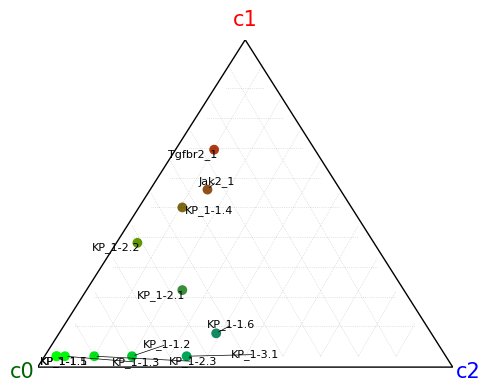

In [367]:
# 创建三角形图
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

plot_df = pdf.T
plot_df.columns = [0, 1, 2]

# 定义三角形的三个顶点坐标
corners = np.array([[-np.sqrt(3), -1], [np.sqrt(3), -1], [0, np.sqrt(3)]])

# 计算每个点的坐标
x = plot_df[0] * corners[0][0] + plot_df[2] * corners[1][0] + plot_df[1] * corners[2][0]
y = plot_df[0] * corners[0][1] + plot_df[2] * corners[1][1] + plot_df[1] * corners[2][1]

# 计算颜色映射
# 归一化三个分量的值
total = plot_df[0] + plot_df[1] + plot_df[2]
g = plot_df[0] / total  # c0 - 绿色分量
b = plot_df[2] / total  # c2 - 黄色分量 
r = plot_df[1] / total  # c1 - 红色分量

# 将RGB值组合成颜色 - 映射到红、黄、蓝
colors = np.column_stack((
    r,                  # 红色 (1,0,0)
    g,  # 黄色 (0,1,0) 
    b                   # 蓝色 (0,0,1)
))

# 添加网格线
n_lines = 10  # 每个轴的网格线数量
for i in range(1, n_lines):
    ratio = i / n_lines 
    # 平行于底边的线
    y_pos = -1 + ratio * (np.sqrt(3) + 1)
    width = 2 * np.sqrt(3) * (1 - ratio)
    x_start = -width/2
    x_end = width/2
    plt.plot([x_start, x_end], [y_pos, y_pos], 'k:', alpha=0.2, linewidth=0.5)
    
    # 平行于左边的线
    angle = np.pi/3
    x_left = -np.sqrt(3) + ratio * 2 * np.sqrt(3)
    y_bottom = -1
    length = (np.sqrt(3)) * 2 * (1 - ratio)
    plt.plot([x_left, x_left + length * np.cos(angle)],
             [y_bottom, y_bottom + length * np.sin(angle)],
             'k:', alpha=0.2, linewidth=0.5)
    
    # 平行于右边的线
    x_right = np.sqrt(3) - ratio * 2 * np.sqrt(3)
    plt.plot([x_right, x_right - length * np.cos(angle)],
             [y_bottom, y_bottom + length * np.sin(angle)],
             'k:', alpha=0.2, linewidth=0.5)

# 绘制散点
sns.scatterplot(x=x, y=y, s=50, c=colors, edgecolor='none', ax=ax)

# 添加标签
text = []
for i, txt in enumerate(plot_df.index):
    text.append(plt.text(x[i], y[i], txt, fontsize=8, ha='center', va='center'))

import adjustText
adjustText.adjust_text(text, x, y, ax=ax, expand_points=(1, 1), expand_text=(1, 1), force_text=(0.5, 0.5), lim=1, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# 绘制三角形边框
triangle = plt.Polygon(corners * 1.1, fill=False, color='black', lw=1)
ax.add_patch(triangle)

# 添加轴标签
ax.text(corners[0][0]-0.2, corners[0][1]-0.2, 'c0', ha='right', color='darkgreen', fontsize=15)
ax.text(corners[1][0]+0.2, corners[1][1]-0.2, 'c2', ha='left', color='blue', fontsize=15)
ax.text(corners[2][0], corners[2][1]+0.3, 'c1', ha='center', color='red', fontsize=15)

ax.set_xlim(-np.sqrt(3) * 1.1, np.sqrt(3) * 1.1)
ax.set_ylim(-1.2, np.sqrt(3) * 1.1)

# 设置图形属性
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/perturb_view_proportion.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
cdf = pd.DataFrame(gdata.X, columns=gdata.var_names, index=gdata.obs_names)
cdf = cdf.loc[:, cdf.sum(axis=0) > 10]
cdf = pd.concat([cdf, gdata.obs.cluster_cellcharter], axis=1)
cdf

In [ ]:
cdf = pd.DataFrame(gdata.X, columns=gdata.var_names, index=gdata.obs_names)
cdf = cdf.loc[:, cdf.sum(axis=0) > 10]
cdf = pd.concat([cdf, gdata.obs.cluster_cellcharter], axis=1)
cdf

In [86]:
c_df = fdata.obs[['leiden', 'phenotypes']]
# c_df.fillna(0, inplace=True)
for phenotype in c_df['phenotypes'].unique():
    c_df[phenotype] = (c_df['phenotypes'] == phenotype).astype(int)
c_df = c_df[['Tgfbr2_1', 'Jak2_1', 'KP_1-1', 'KP_1-2', 'KP_1-3', 'periphery', 'leiden']]
c_df['all'] = c_df.loc[:, c_df.columns != 'leiden'].sum(axis=1)
c_df.head()

,Tgfbr2_1,Jak2_1,KP_1-1,KP_1-2,KP_1-3,periphery,leiden,all
ACGGCGGGTTGCCCTG-1,0,0,0,0,0,0,0,0
GTGCGCAGCTTGCTCC-1,0,0,0,0,0,0,0,0
TCACTATCGTGCAATC-1,0,0,0,0,0,0,1,0
AGTCACTCCGCCTCAT-1,0,0,0,0,0,0,1,0
GCAGCGGTGGGCATTA-1,0,0,0,0,0,0,3,0


In [101]:
import warnings
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
warnings.filterwarnings('ignore')
from tqdm import tqdm

p_value = {}
for guide in tqdm(c_df.columns):
    if guide == 'all' or guide == 'leiden': continue
    for perm_metrics in ['jensenshannon']:
        print(perm_metrics)
        g_df = c_df[[guide, "all", "leiden"]]

        masks = {c: (g_df.leiden == c) for c in g_df.leiden.unique()}
        df = pd.DataFrame(columns=range(2))

        guide_cnts = np.array(pd.concat([df, g_df.groupby(['leiden', guide]).count().unstack()['all']], axis=0).fillna(0))
        ntc_cnts = np.array(pd.concat([df, g_df.groupby(['leiden', 'all']).count().unstack()[guide]], axis=0).fillna(0))
        data = np.vstack([guide_cnts, ntc_cnts])
        sample_ids = np.array([[name + str(c) for c in g_df.leiden.unique()] for name in ['guide_', 'control_']]).flatten()

        dist_matrix = squareform(pdist(data, metric=perm_metrics))
        metadata = pd.DataFrame({
            'group': ['A'] * 6 + ['B'] * 6
        }, index=sample_ids)
        dm = DistanceMatrix(dist_matrix, ids=sample_ids)

        results = permanova(dm, metadata, column='group', permutations=1000)
        p_value[guide] = results['p-value']

  0%|          | 0/8 [00:00<?, ?it/s]

jensenshannon


 12%|█▎        | 1/8 [00:06<00:45,  6.49s/it]

jensenshannon


 25%|██▌       | 2/8 [00:13<00:39,  6.51s/it]

jensenshannon


 38%|███▊      | 3/8 [00:19<00:32,  6.50s/it]

jensenshannon


 50%|█████     | 4/8 [00:25<00:25,  6.47s/it]

jensenshannon


 62%|██████▎   | 5/8 [00:32<00:19,  6.45s/it]

jensenshannon


100%|██████████| 8/8 [00:38<00:00,  4.84s/it]


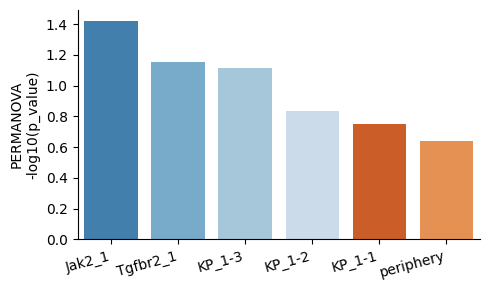

In [104]:
plt.figure(figsize=(5, 3))
pdf = pd.DataFrame(p_value.items(), columns=['guide', 'p_value']).sort_values(by='p_value')
pdf['-log10(p_value)'] = -np.log10(pdf['p_value'])
sns.barplot(x='guide', y='-log10(p_value)', data=pdf, palette='tab20c')
sns.despine()

plt.xlabel('')
plt.ylabel('PERMANOVA\n-log10(p_value)')
plt.title('')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('./supplementary_images/spot_control_permanova.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [37]:
from scipy.stats import wasserstein_distance
import statsmodels.api as sm
from tqdm import tqdm

kde_dict = {}
for n_bins in [10]:
    kde_dict[n_bins] = {}
    x_grid = np.linspace(fdata.obsm['spatial'][:, 0].min(), fdata.obsm['spatial'][:, 0].max(), n_bins)
    y_grid = np.linspace(fdata.obsm['spatial'][:, 1].min(), fdata.obsm['spatial'][:, 1].max(), n_bins)

    for guide in ['Tgfbr2_1', 'Jak2_1', 'KP_1-1', 'KP_1-2', 'KP_1-3', 'periphery', 'all']:
        cnt_grid = np.arange(0, 2, 0.5)

        X, Y, CNT = np.meshgrid(x_grid, y_grid, cnt_grid)

        if guide != 'all':
            kde = sm.nonparametric.KDEMultivariate(data=[fdata.obsm['spatial'][:, 0],
                                                        fdata.obsm['spatial'][:, 1],
                                                        (fdata.obs['phenotypes'] == guide).astype(int)],
                                var_type='cco',  # 'c' for continuous
                                bw='normal_reference')  # 使用默认的带宽选择方法
        else:
            kde = sm.nonparametric.KDEMultivariate(data=[fdata.obsm['spatial'][:, 0],
                                                        fdata.obsm['spatial'][:, 1],
                                                        (~fdata.obs['phenotypes'].isna()).astype(int)],
                                var_type='cco',  # 'c' for continuous
                                bw='normal_reference')  # 使用默认的带宽选择方法

        grid_coords = np.column_stack([X.ravel(), Y.ravel(), CNT.ravel()])
        kde_values = kde.pdf(grid_coords).reshape(X.shape)
        kde_matrix = np.zeros((kde_values.shape[0], kde_values.shape[1]))
        for i in range(kde_values.shape[2]):
            kde_matrix += kde_values[:, :, i] * cnt_grid[i]
        kde_dict[n_bins][guide] = kde_matrix
kde_dict

{10: {'Tgfbr2_1': array([[5.15231200e-10, 3.03306384e-09, 8.28861324e-09, 2.19855346e-08,
          4.73635884e-08, 2.09560422e-08, 1.89288526e-09, 1.56950489e-10,
          5.47255619e-12, 2.96447414e-14],
         [2.97050142e-09, 1.10182866e-08, 2.02149964e-08, 4.44514225e-08,
          8.60131433e-08, 4.08783470e-08, 7.60755502e-09, 1.34747378e-09,
          6.10615857e-11, 6.15089172e-13],
         [5.34294825e-09, 1.67147982e-08, 2.49546595e-08, 3.93196999e-08,
          6.04841418e-08, 3.58280870e-08, 1.57983177e-08, 4.17423261e-09,
          2.73703122e-10, 2.46953659e-11],
         [4.17293041e-09, 1.56544337e-08, 2.39827632e-08, 2.78845798e-08,
          3.10691172e-08, 2.71048324e-08, 1.88826814e-08, 5.86762720e-09,
          1.26807104e-09, 6.11389696e-10],
         [2.19861391e-09, 1.05778766e-08, 1.93440684e-08, 2.42090932e-08,
          2.60474647e-08, 2.54731385e-08, 1.86495395e-08, 8.22804984e-09,
          6.26990083e-09, 3.71469138e-09],
         [6.80108113e-10, 5.6

In [38]:
wasserstein_dict = {}
for n_bins in [10]:
    wasserstein_dict[n_bins] = {}
    for guide in ['Tgfbr2_1', 'Jak2_1', 'KP_1-1', 'KP_1-2', 'KP_1-3', 'periphery']:
        wasserstein_dict[n_bins][guide] = wasserstein_distance(kde_dict[n_bins]['all'].ravel(), kde_dict[n_bins][guide].ravel())
wasserstein_dict

{10: {'Tgfbr2_1': 2.741281388994802e-08,
  'Jak2_1': 3.3587170861540725e-08,
  'KP_1-1': 2.394678008431288e-08,
  'KP_1-2': 2.7150900912713835e-08,
  'KP_1-3': 3.019406873577546e-08,
  'periphery': 2.0709903935625976e-08}}

/tmp/ipykernel_65536/1492729791.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(wasserstein_dict[10].keys()), y=list(wasserstein_dict[10].values()), palette='tab20c')


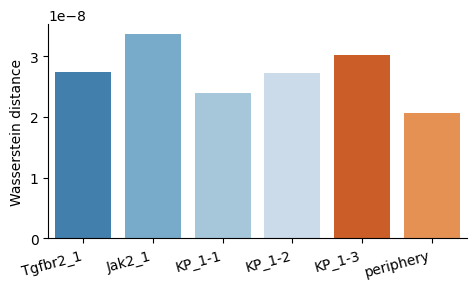

In [46]:
plt.figure(figsize=(5, 3))
sns.barplot(x=list(wasserstein_dict[10].keys()), y=list(wasserstein_dict[10].values()), palette='tab20c')
sns.despine()

plt.xlabel('')
plt.ylabel('Wasserstein distance')
plt.title('')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('./supplementary_images/spot_control_wasserstein.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [18]:
import cluster_independent

cluster_independent.rank_by_kernel_estimated_distance(fdata, 'peripheral')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects